# Model Training (S1U)

2025/1/23

In [1]:
import numpy as np

def preprocess_data(sample):
    # 截取并调整每个样本为 (4, 240, 1)
    return np.transpose(sample[:, 0:4, 0:240], (1, 2, 0))

def normalize_data(data):
    # 将数据归一化到 [0, 1] 之间
    return data / 4.0

def data_generator(data_files, label_files, batch_size):
    while True:
        for start in range(0, len(data_files), batch_size):
            end = min(start + batch_size, len(data_files))
            batch_data = []
            batch_labels = []
            for i in range(start, end):
                sample = np.load(data_files[i])
                label = np.load(label_files[i])
                preprocessed_sample = preprocess_data(sample)
                normalized_sample = normalize_data(preprocessed_sample)
                batch_data.append(normalized_sample)
                batch_labels.append(label)
            yield np.array(batch_data), np.array(batch_labels)

In [2]:
import os
from sklearn.model_selection import train_test_split

data_dir = 'simulation/out/S1U/numpy_data/seq'
label_dir = 'simulation/out/S1U/numpy_data/label'

data_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.npy')])
label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.npy')])

# 使用 train_test_split 进行数据集划分
train_data_files, val_data_files, train_label_files, val_label_files = train_test_split(
    data_files, label_files, test_size=0.2, random_state=42)

batch_size = 32
steps_per_epoch = len(train_data_files) // batch_size
validation_steps = len(val_data_files) // batch_size

In [3]:
from fusang import get_dl_model_240

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

model = get_dl_model_240()

model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

history = model.fit(
    data_generator(train_data_files, train_label_files, batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=data_generator(val_data_files, val_label_files, batch_size),
    validation_steps=validation_steps
)

2025-01-23 18:53:33.076989: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-23 18:53:33.278404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737629613.338742 1783429 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737629613.356177 1783429 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 18:53:33.526982: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Epoch 1/10


E0000 00:00:1737629629.741763 1783429 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1737629630.817747 1783580 cuda_dnn.cc:529] Loaded cuDNN version 90300


15000/15000 ━━━━━━━━━━━━━━━━━━━━ 2495s 165ms/step - loss: 0.4249 - sparse_categorical_accuracy: 0.8234 - val_loss: 0.2827 - val_sparse_categorical_accuracy: 0.8801
Epoch 2/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 2454s 164ms/step - loss: 0.2968 - sparse_categorical_accuracy: 0.8772 - val_loss: 0.2669 - val_sparse_categorical_accuracy: 0.8857
Epoch 3/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 1839s 123ms/step - loss: 0.2797 - sparse_categorical_accuracy: 0.8828 - val_loss: 0.2581 - val_sparse_categorical_accuracy: 0.8899
Epoch 4/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 1865s 124ms/step - loss: 0.2724 - sparse_categorical_accuracy: 0.8861 - val_loss: 0.2543 - val_sparse_categorical_accuracy: 0.8918
Epoch 5/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 1888s 126ms/step - loss: 0.2672 - sparse_categorical_accuracy: 0.8874 - val_loss: 0.2510 - val_sparse_categorical_accuracy: 0.8916
Epoch 6/10
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 1942s 129ms/step - loss: 0.2633 - sparse_categorical_accuracy: 0.8884 - val_loss: 0.2498 - v

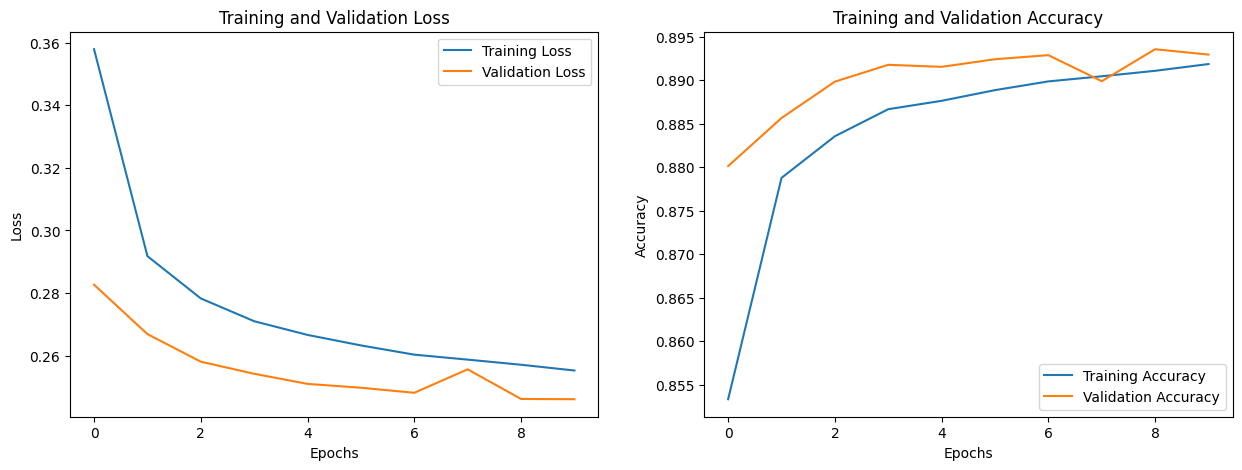

In [4]:
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # 1行2列，图形大小15x5

# 绘制训练和验证的损失值曲线
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# 绘制训练和验证的准确率曲线
ax2.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()